In [1]:
import pandas as pd
from collections import Counter
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import anbiopy as ab

## Data

In [3]:
#Anthro data
antro_data = pd.read_csv('./../../../Data/Consolidated/anthro_data.meta', sep = '\t')

#OTU data
otu_data = pd.read_csv('./../../../Data/Consolidated/otu_data.otus', sep = '\t')

#Food group data
fg_data = pd.read_csv('./../../../Data/Consolidated/food_groups_u24h.csv')

#Nutrients data
nutrients_data = pd.read_csv('./../../../Data/Consolidated/nutrients_data.txt', sep = '\t')

#OTU Tree
tree_file = "./../../../Data/Consolidated/tree_data.tre"
with open(tree_file, "r") as f:
    tree = f.read()

#Taxonomy data
otu_taxonomy = pd.read_csv('./../../../Data/Consolidated/otu_taxonomy.taxonomy', sep = '\t')

In [4]:
antro_data.columns

Index(['ID', 'city', 'socioeconomic', 'sex', 'age', 'age_range', 'HDL', 'LDL',
       'cholesterol', 'triglycerides', 'hsCRP', 'glucose', 'glycosylated_hg',
       'adiponectin', 'insulin', 'HOMA_IR', 'stool_consistency', 'hiden_blood',
       'systolic_bp', 'diastolic_bp', 'bmi', 'bmi_class', 'body_fat', 'waist',
       'medicament', 'fiber', 'per_protein', 'per_animal_protein',
       'per_total_fat', 'per_saturated_fat', 'per_monoinsaturated_fat',
       'per_polyunsaturated_fat', 'per_carbohydrates'],
      dtype='object')

In [5]:
#Taxonomic table
taxo_df = ab.taxonomy_df(otu_taxonomy)
taxo_df.head()

,OTU,Size,Kingdom,Phylum,Class,Order,Family,Genus,Species
0,Otu00001,136589,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella,copri
1,Otu00002,1139018,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella,copri
2,Otu00003,452087,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Gemmiger,formicilis
3,Otu00004,1182065,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Escherichia,coli
4,Otu00005,265091,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Faecalibacterium,prausnitzii


## Analysis and Objective

Cardiometabolic health is defined as a function of the following variables:
1. Systolic BP (high)
2. Diastolic BP (high)
3. triglycerides (high)
4. HDL (low)
5. Glocuse (high)
6. HOMA-IR (high)
7. hsCRP (high)

The objective of this analysis is identifying OTUs that have a high importance for predicting these variable, in any of the taxonomic levels. Once these OTUs are identified, we test graphically and statistically if there is any clear relationship with the objetive variables. 

## Data preparation
For this analysis we must perform 2 adjustments:
1. Remove observation MI_354_H from the data, as it has a NA value for Systolic BP
2. Use only the observations of individuals that DO NOT consume medicaments, as it is a generic variable for multiple medicaments that probably have an effect on cardiometabolic health.

Additionally, to have all data readily available, we can obtain a create version of the taxonomic table

In [6]:
#Remove MI_354_H
id_remove = ['MI_354_H']

antro_data = antro_data[~antro_data['ID'].isin(id_remove)]

antro_filtered = antro_data[antro_data['medicament']=='No']

otu_filtered = otu_data[otu_data['ID'].isin(antro_filtered['ID'])]

In [7]:
variables_chs = ['systolic_bp', 'diastolic_bp', 'triglycerides', 'HDL', 'glucose', 'HOMA_IR', 'hsCRP']

## Target variable selection

The variables that define the cardiametabolic health tend to be highly correlated. Thus, it is a good idea to use this to reduce the number of target variables in the analysis. 

Summary:
- Using correlations and VIF, we found that both blood pressures are highly correlated. We chose to use only Systolic BP
- Using correlations we found that HDL and Triglycered are correlated. We chose to use only Tryglicerides

In [8]:
#CHS Variables data
data_chs = antro_filtered[variables_chs]

<Axes: >

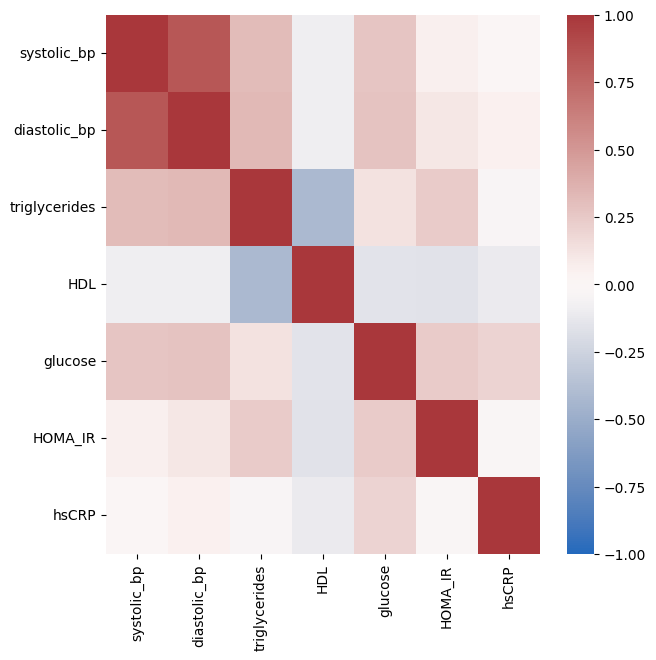

In [9]:
#First we check the existing correlations
plt.figure(figsize = (7, 7))
sns.heatmap(data_chs.corr(), cmap = 'vlag', vmin = -1, vmax = 1)

In [10]:
#Computation of VIF
X = add_constant(data_chs)
VIF = pd.DataFrame()
VIF['Variable'] = X.columns
VIF['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
VIF

,Variable,VIF
0,const,165.879366
1,systolic_bp,3.422568
2,diastolic_bp,3.480002
3,triglycerides,1.417069
4,HDL,1.257779
5,glucose,1.208296
6,HOMA_IR,1.129437
7,hsCRP,1.083417


In [11]:
#Removed target variables
variables_chs_exlude = []

#Between Systolic BP and Diastolic BP there is a high correlattion, also, they have a high VIF. Diastolic goes 
variables_chs_exlude.append('diastolic_bp')

#Trigliceridos and HDL don't have a particularly high VIF, but their correlation is relatively high. HDL goes
variables_chs_exlude.append('HDL')

In [12]:
#We elimiminate this variables for the anthropometric data
antro_filtered = antro_filtered.drop(columns = variables_chs_exlude)

## Analysis 

In [13]:
results_levels = []
taxonomic_levels = ['Class', 'Order', 'Family', 'Genus']

### Identify relevant factors in each taxonomic level for each variable

#### 1. Systolic BP

Estimating model for Class
Estimating model for Order
Estimating model for Family
Estimating model for Genus


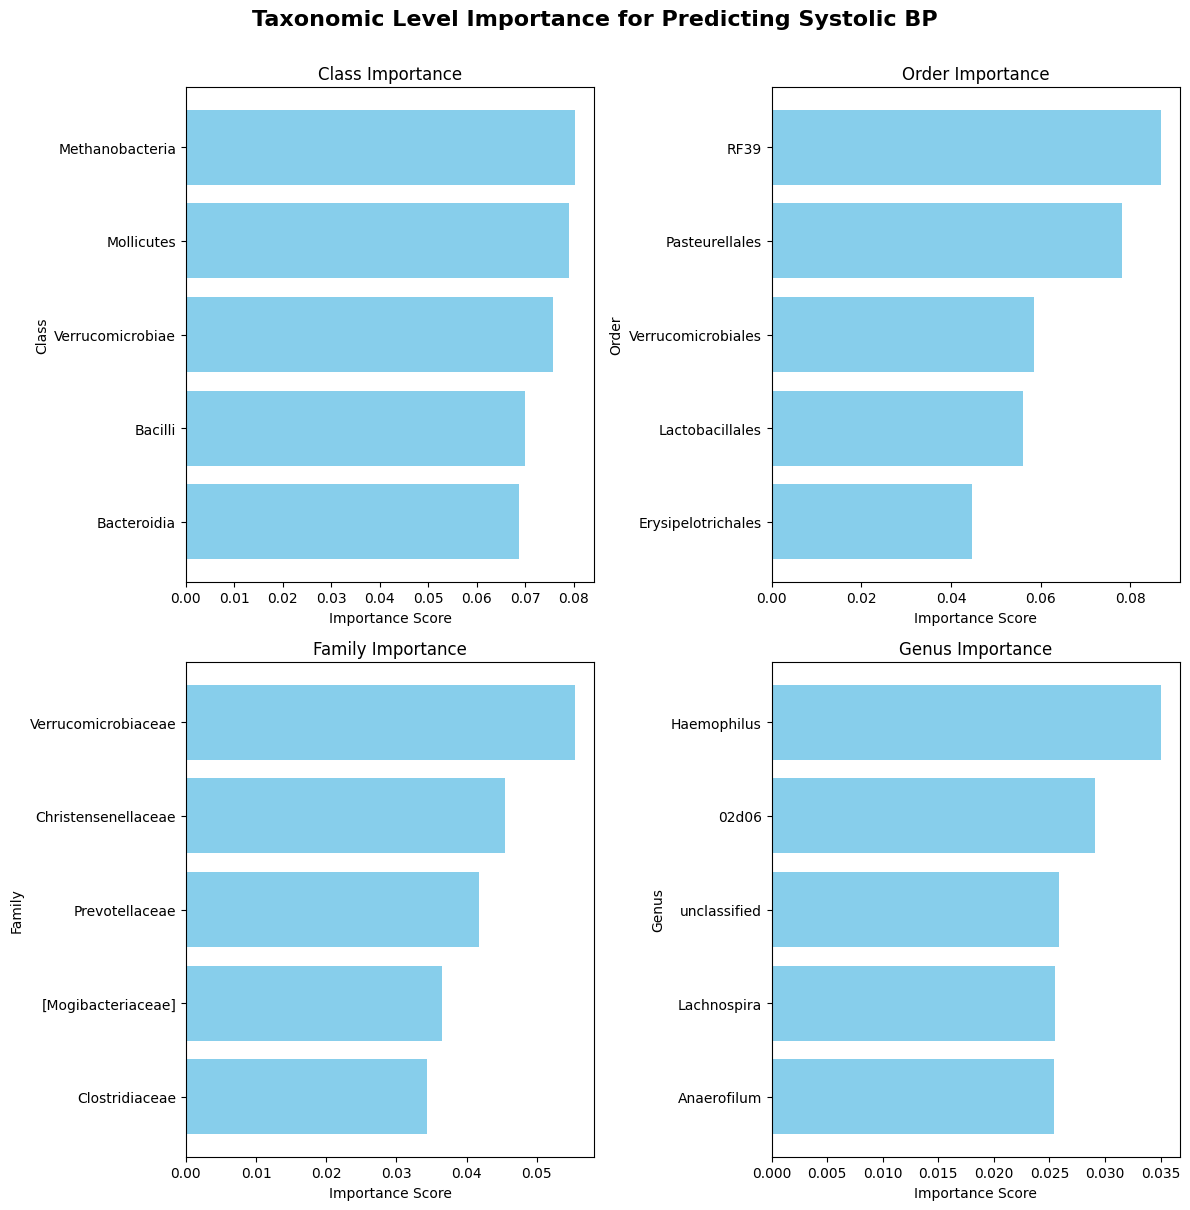

In [14]:
#Multiple levels 
multi_sbp = ab.multi_level_factors(otus = otu_filtered, 
                                 otu_taxonomy = taxo_df,
                                 Y = antro_filtered['systolic_bp'],
                                 Y_name = 'Systolic BP',
                                 levels = ['Class', 'Order', 'Family', 'Genus'],
                                 classification = False,
                                 includes_ids = True,
                                 max_rows = 5,
                                 relative = True,
                                 seed = 2302, 
                                 save_file = True,
                                 file_name = "sBP_COFG")
results_levels.append(multi_sbp)

#### 2. Triglycerides

Estimating model for Class
Estimating model for Order
Estimating model for Family
Estimating model for Genus


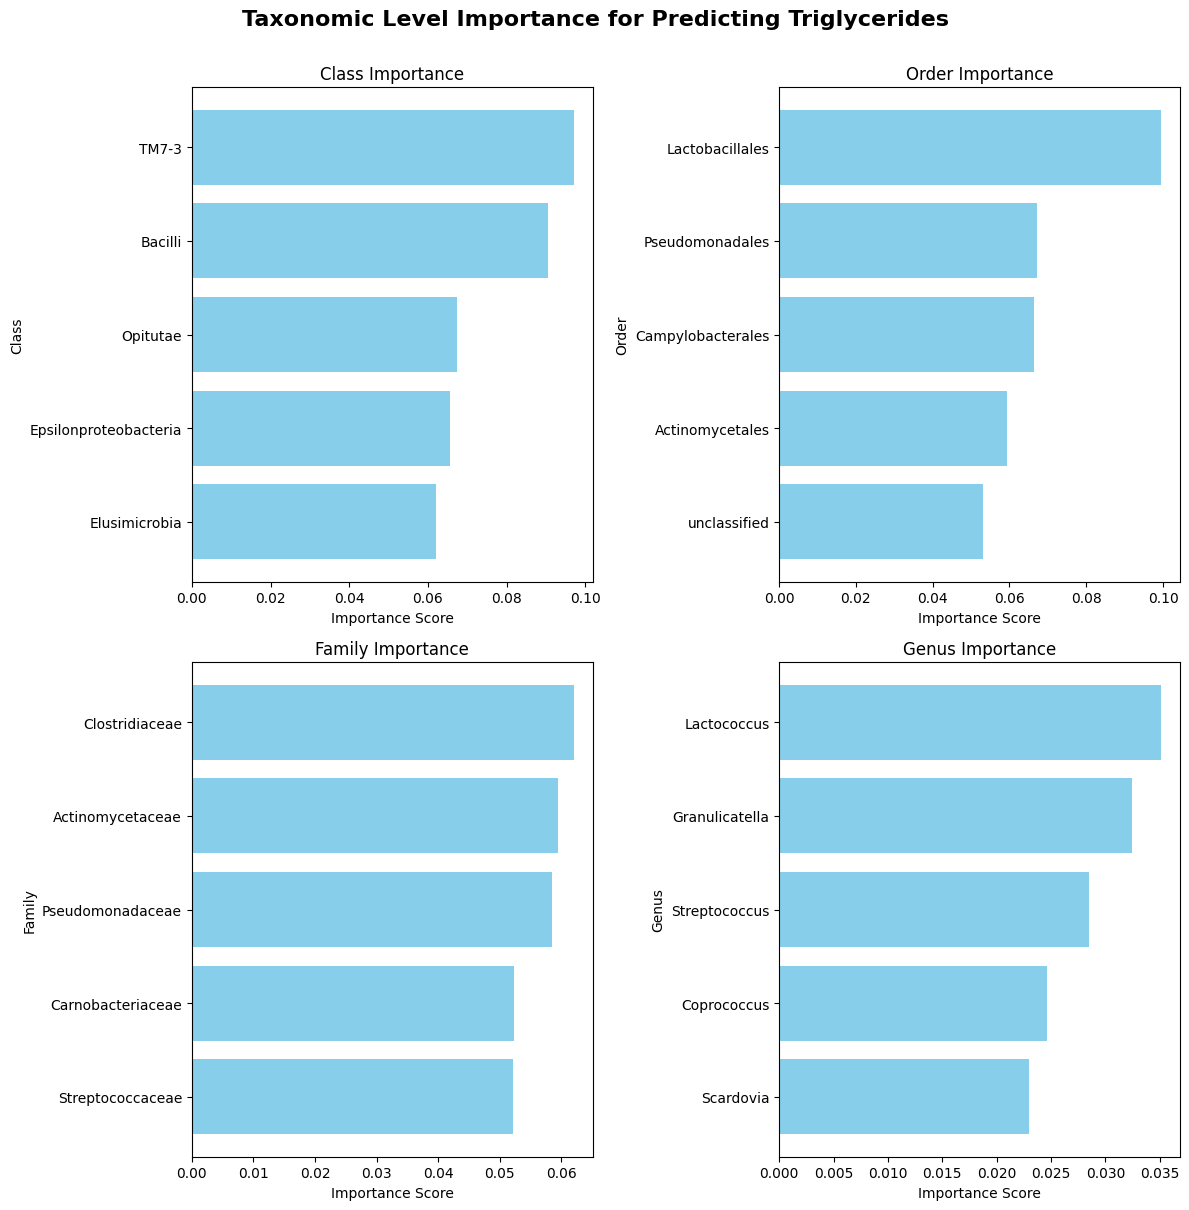

In [15]:
#Multiple levels 
multi_trig = ab.multi_level_factors(otus = otu_filtered, 
                                 otu_taxonomy = taxo_df,
                                 Y = antro_filtered['triglycerides'],
                                 Y_name = 'Triglycerides',
                                 levels = ['Class', 'Order', 'Family', 'Genus'],
                                 classification = False,
                                 includes_ids = True,
                                 max_rows = 5,
                                 relative = True,
                                 seed = 2302, 
                                 save_file = True,
                                 file_name = "trig_COFG")
results_levels.append(multi_trig)

#### 3. Glocuse

Estimating model for Class
Estimating model for Order
Estimating model for Family
Estimating model for Genus


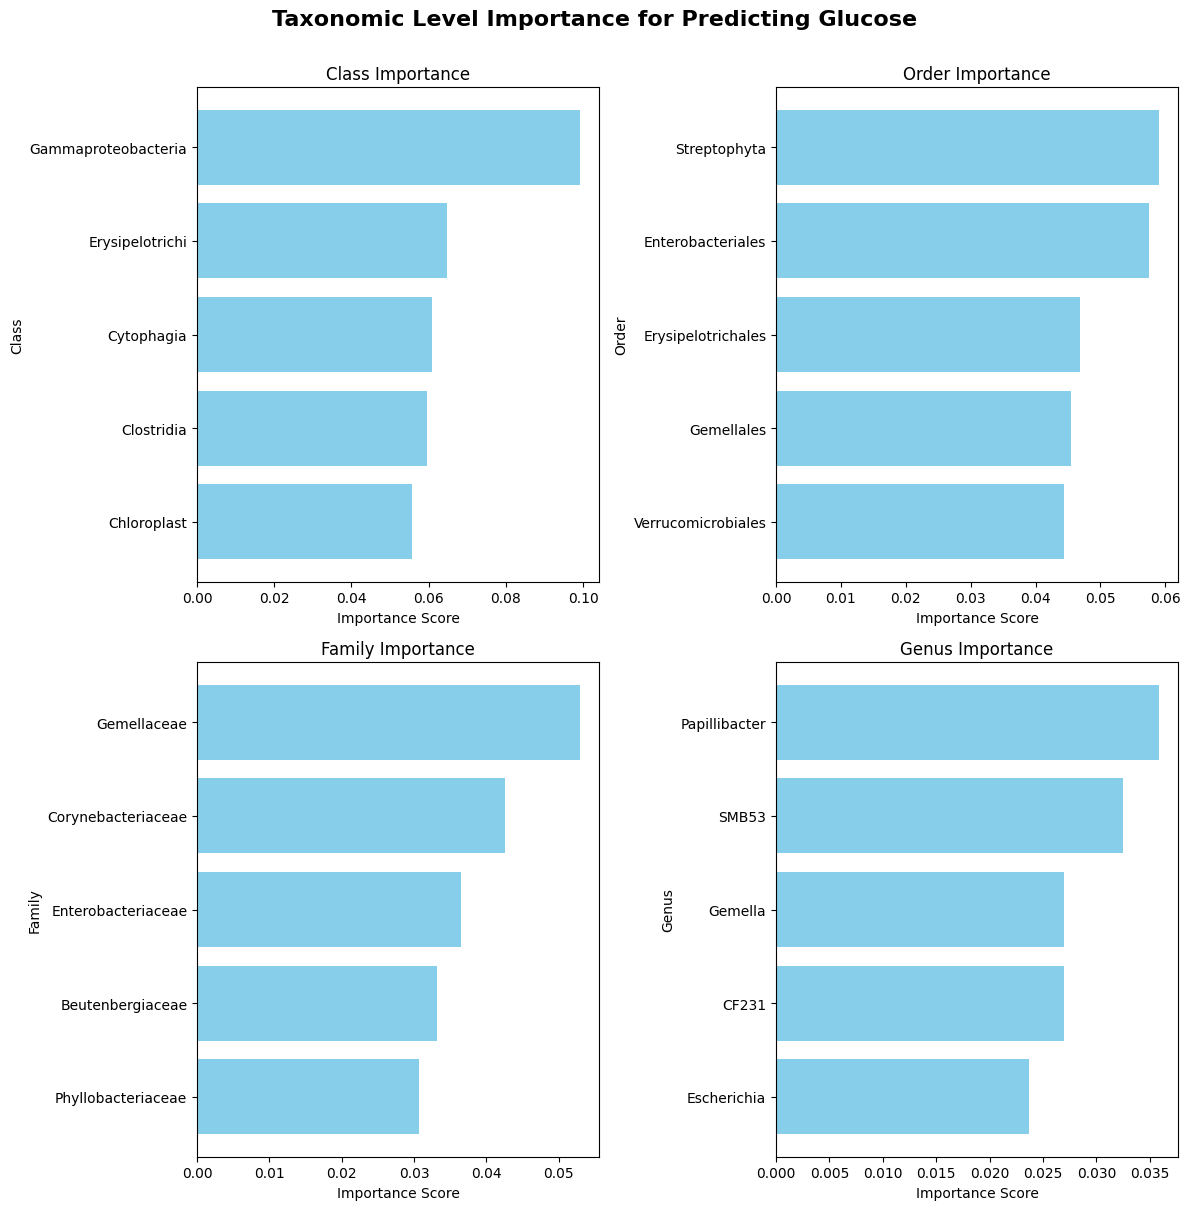

In [16]:
#Multiple levels 
multi_glu = ab.multi_level_factors(otus = otu_filtered, 
                                 otu_taxonomy = taxo_df,
                                 Y = antro_filtered['glucose'],
                                 Y_name = 'Glucose',
                                 levels = ['Class', 'Order', 'Family', 'Genus'],
                                 classification = False,
                                 includes_ids = True,
                                 max_rows = 5,
                                 relative = True,
                                 seed = 2302, 
                                 save_file = True,
                                 file_name = "glu_COFG")
results_levels.append(multi_glu)

#### 4. HOMA-IR

Estimating model for Class
Estimating model for Order
Estimating model for Family
Estimating model for Genus


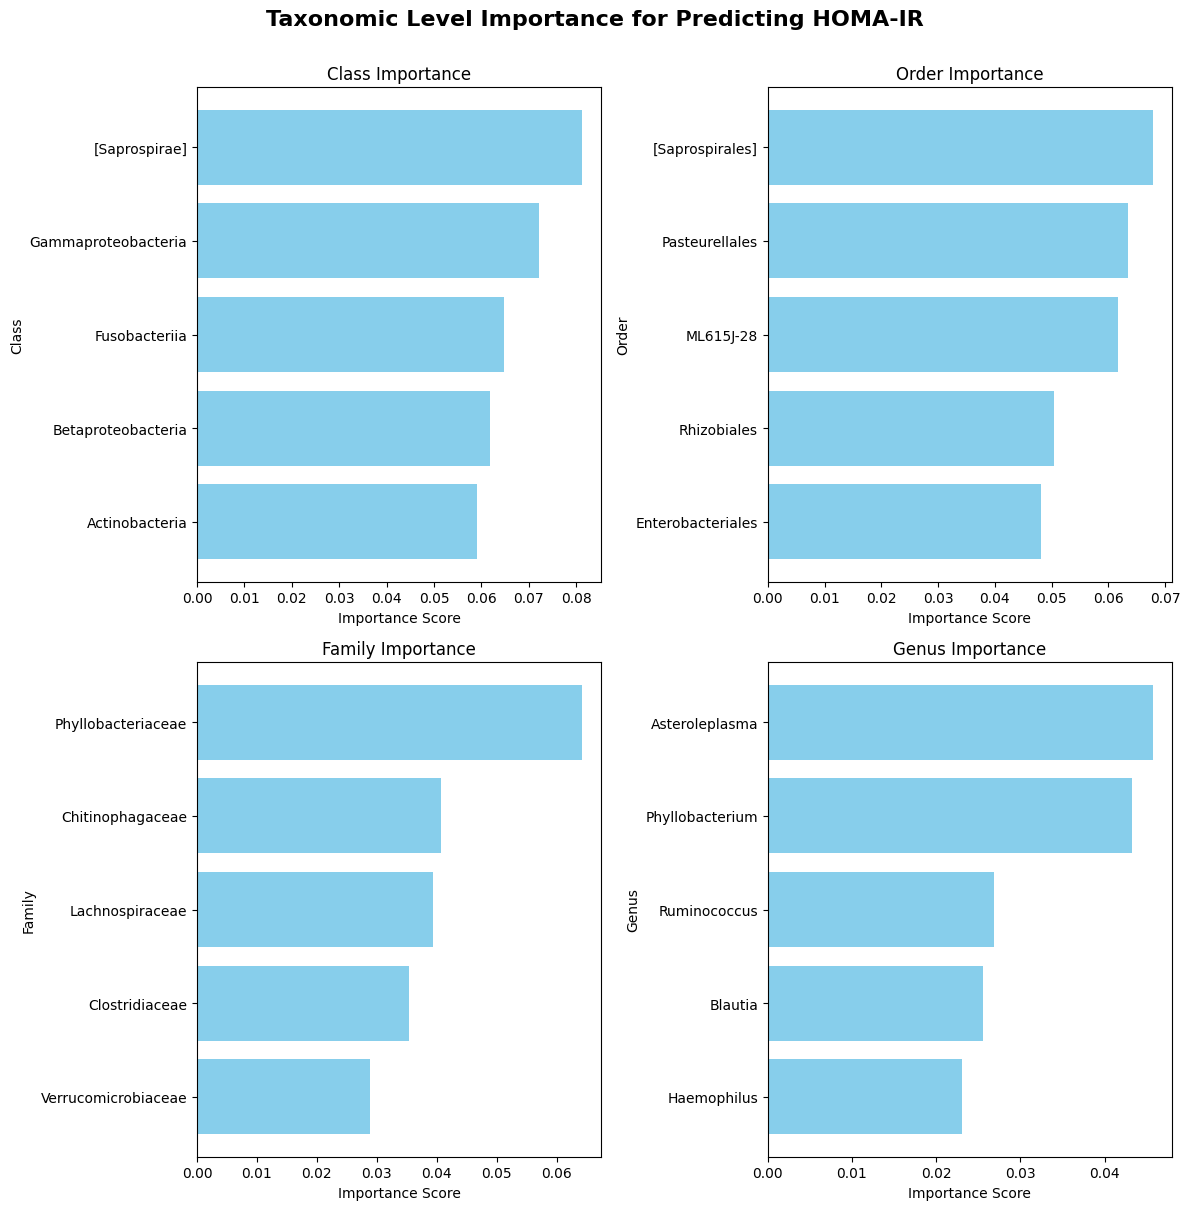

In [17]:
#Multiple levels 
multi_homa = ab.multi_level_factors(otus = otu_filtered, 
                                 otu_taxonomy = taxo_df,
                                 Y = antro_filtered['HOMA_IR'],
                                 Y_name = 'HOMA-IR',
                                 levels = ['Class', 'Order', 'Family', 'Genus'],
                                 classification = False,
                                 includes_ids = True,
                                 max_rows = 5,
                                 relative = True,
                                 seed = 2302, 
                                 save_file = True,
                                 file_name = "homa_COFG")
results_levels.append(multi_homa)

#### 5. hsCRP

Estimating model for Class
Estimating model for Order
Estimating model for Family
Estimating model for Genus


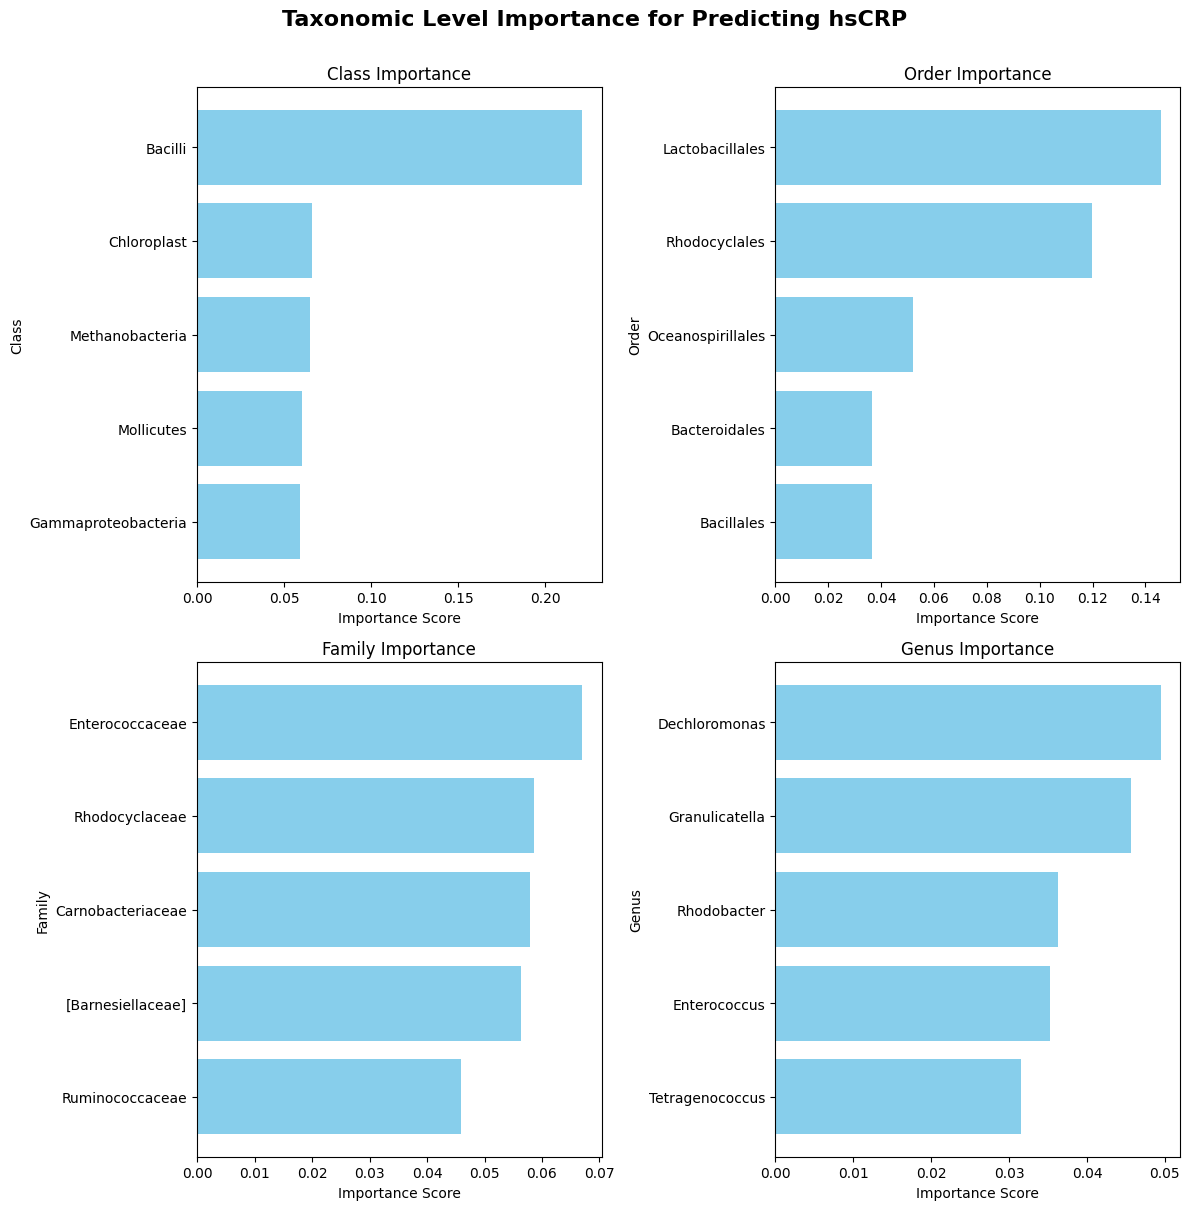

In [18]:
#Multiple levels 
multi_hsCRP = ab.multi_level_factors(otus = otu_filtered, 
                                 otu_taxonomy = taxo_df,
                                 Y = antro_filtered['hsCRP'],
                                 Y_name = 'hsCRP',
                                 levels = ['Class', 'Order', 'Family', 'Genus'],
                                 classification = False,
                                 includes_ids = True,
                                 max_rows = 5,
                                 relative = True,
                                 seed = 2302, 
                                 save_file = True,
                                 file_name = "hscrp_COFG")
results_levels.append(multi_hsCRP)

### Identify in which taxonomic level are the 5 factors with the highest average importance
With the objective of determinig in which level to focus the analysis, we look for the taxonomic level with the highest average of top 5 importances for each variable. In other words, the taxonomic level that, acroos all avariables, has the 5 groups with highest average importance. 

**Result:** The determined taxonomic level was Class

In [19]:
level_importances = []

In [20]:
level_max_importance = -1
max_importance = 0

In [21]:
for i in range(4):

    #Importances of the taxonomic level
    importances = []

    for result in results_levels:
        #Current result for the taxonomic level
        result_curr = result[i]
        #Top 5 factores
        result_curr.head(5)

        #Average of the five highest importances
        curr_avg = result_curr['Importance'].mean()
        importances.append(curr_avg)

    #We compute the average of all importances Sacamos el promedio de las importancias
    curr_level_avg = sum(importances) / len(importances)

    if curr_level_avg > max_importance:
        max_importance = curr_level_avg
        level_max_importance = i
    level_importances.append(curr_level_avg)
    

In [22]:
level_importances

[np.float64(0.01818181818181818),
 np.float64(0.010101010101010102),
 np.float64(0.005681818181818182),
 np.float64(0.002325581395348837)]

In [23]:
level_max_importance, max_importance

(0, np.float64(0.01818181818181818))

### Analysis of the chosen taxonomic level

Once determined that the taxonomic level for the specific analysis is Class, now we look for which groups within Class are important factors for predicting the our target CHS variables. 

**Results:**
1. Bacilli and Gammaproteobacteria are present in 3 of 5 tops. We decide to look more in depth about the relationship of Bacilli with our target variables

In [24]:
top_classes = []
for model in results_levels:
    #Top 5 grupos
    top = model[0].head(5)
    top_classes = top_classes + top['Class'].to_list()

In [25]:
class_counter = Counter(top_classes)
print(class_counter)

Counter({'Bacilli': 3, 'Gammaproteobacteria': 3, 'Methanobacteria': 2, 'Mollicutes': 2, 'Chloroplast': 2, 'Verrucomicrobiae': 1, 'Bacteroidia': 1, 'TM7-3': 1, 'Opitutae': 1, 'Epsilonproteobacteria': 1, 'Elusimicrobia': 1, 'Erysipelotrichi': 1, 'Cytophagia': 1, 'Clostridia': 1, '[Saprospirae]': 1, 'Fusobacteriia': 1, 'Betaproteobacteria': 1, 'Actinobacteria': 1})


### Analysis of the selected class

Knowing that Bacilli is a group within Class most frequenly within the top 5 predictors for the CHS varibles, it is worth analyzing it: grouping and not the OTUs belonging to it.

#### Analysis grouping OTUs:
The key questions were:
1. Graphically, is there any clear relationship between the relative abundance of Bacilli with any of the CHS variables?
2. Is the relative abundance of Bacilli the same in different cities?

**Results:**
1. Graphically, there is no clear linear relantionship between the relative abundance of Bacilli and any of the target variables.
2. Statistical results:
- ANOVA Model: City is a significant factor for explaning the relative abundance of Bacilli. However, the model does not meet all the model's assumptions.
- Kruskal-Wallis H test: The median abundance of Bacilli is significantly different between different cities.

**Takeaways:**
- Despite the absence of a clear linear relationship between Bacilli and any of the CHS variables, the method of identification of factors determines that it is an important variables for predicting the. This might be due to the fact that the relationship is not linear, or that there are confounding factors that affect these relationships.
- The relative abundance of Bacilli is different between cities, therefore its effect on the CHS variables might also be different for individuals residing in different places.  

##### Group OTUs

In [26]:
#Relative abundances
otu_relative = otu_filtered.drop(columns = ['ID'])
otu_relative = ab.relative_abundances(otu_relative)

In [27]:
#We create the grouped df for class
otu_relative_class = ab.create_level_df(otu_relative, taxo_df, 'Class')
otu_relative_class

,Bacteroidia,Clostridia,Gammaproteobacteria,Verrucomicrobiae,Actinobacteria,Methanobacteria,Coriobacteriia,Erysipelotrichi,Bacilli,Mollicutes,...,Aquificae,[Spartobacteria],Chlamydiia,Chloroflexi,Phycisphaerae,Solibacteres,PBS-25,[Saprospirae],Oscillatoriophycideae,Chthonomonadetes
0,0.091763,0.631026,0.016680,0.024506,0.033718,0.011448,0.098515,0.000626,0.031437,0.054154,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.022626,0.413803,0.078559,0.257367,0.016338,0.094568,0.046817,0.015580,0.010126,0.036236,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.007049,0.485352,0.054552,0.000000,0.211659,0.000000,0.118490,0.016669,0.105261,0.000033,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.259511,0.575529,0.004148,0.000000,0.045291,0.000013,0.039218,0.054337,0.004846,0.015455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.030913,0.669442,0.005059,0.025774,0.022029,0.011035,0.203442,0.016054,0.014500,0.000239,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,0.152476,0.417804,0.311835,0.000010,0.003626,0.000000,0.010849,0.053996,0.007571,0.037025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
425,0.193732,0.242705,0.518591,0.000000,0.001629,0.002585,0.012075,0.007118,0.006728,0.005630,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
428,0.354563,0.393384,0.061310,0.003779,0.001726,0.010918,0.018244,0.004153,0.029349,0.078621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
431,0.608952,0.237728,0.050349,0.000032,0.000473,0.006250,0.017930,0.005556,0.003314,0.047950,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Graphicall relantionships vs CHS variables

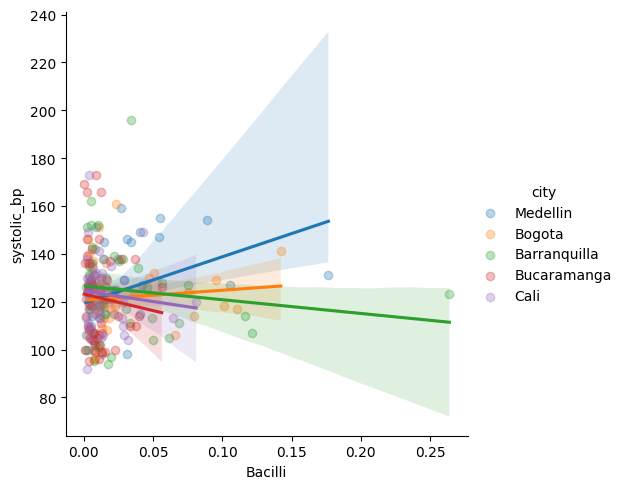

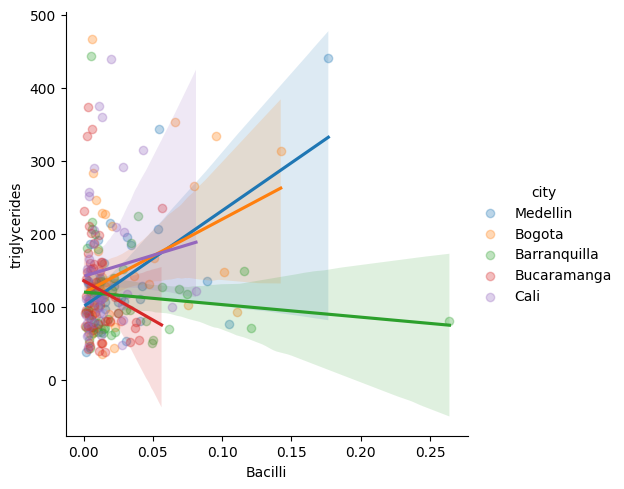

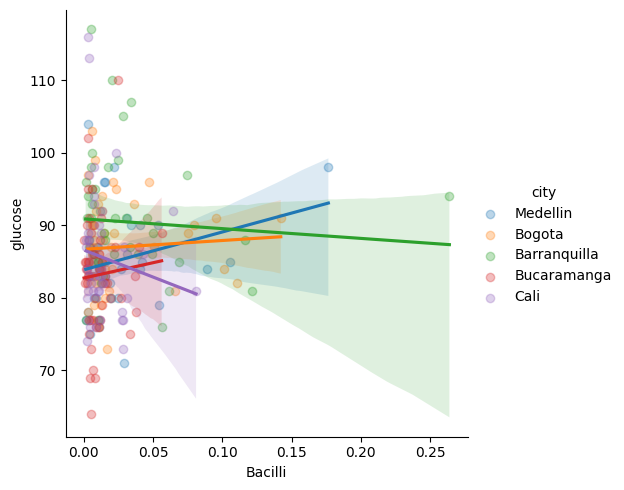

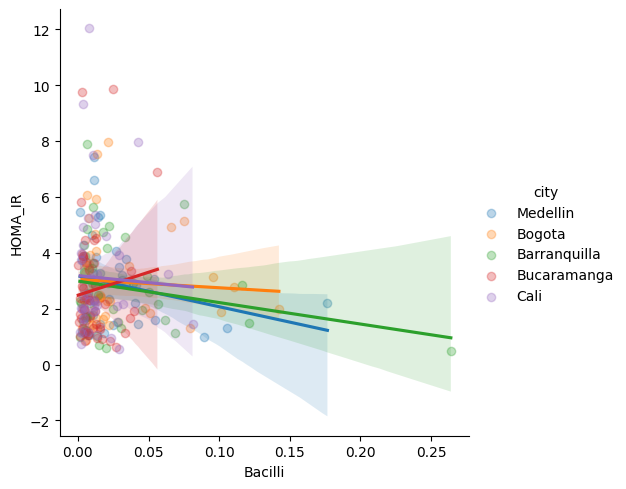

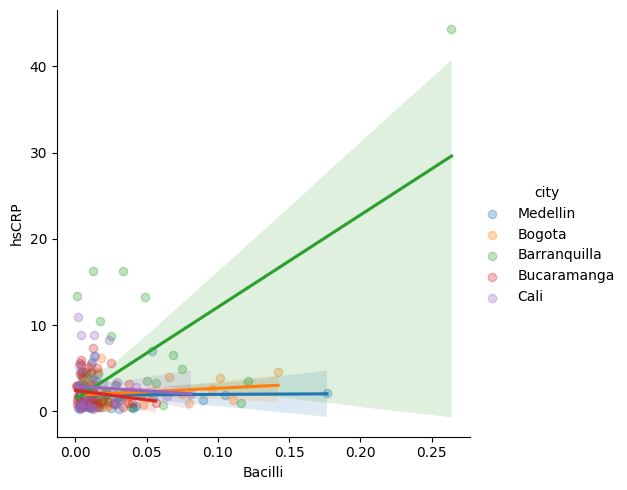

In [28]:
#Is there any graphical relationships with the target variables?
variables_chs = ['systolic_bp', 'triglycerides', 'glucose', 'HOMA_IR', 'hsCRP']

for variable in variables_chs:
    #We create a graphic
    ab.create_graphic(Y = antro_filtered[variable], 
                 X = pd.concat([otu_relative_class['Bacilli'], antro_data['city']], axis = 1),
                 graphic_type = 3, 
                 save_file = True, 
                 file_name = f"Grafica_{variable}vsBacilli")

##### Statistical relationships

Is the abundance of these OTUs the same for men and women?

In [29]:
#Anova
ab.anova_test(Y = otu_relative_class['Bacilli'], 
           data = antro_filtered,
           X_columns = ['city'],
           alpha = 0.05)


Analysis of Variance Table

             Df  Sum Sq  Mean Sq  F value    Pr(>F)
C(city)     4.0  0.0153   0.0038   4.1921  0.002736
Residual  215.0  0.1957   0.0009      NaN       NaN


Levene's Test for Homocedasticity. H0: There is no hetecedasticity
	Levene statistic: 3.0855678989124775
	Levene statistic p-value: 0.01693645139745249


Shapiro Test for Error Normality. H0: Population is distributed normally
	Shapiro statistic: 0.6717151302316896
	Shapiro statistic p-value: 1.9893074513661493e-20


Durbin-Watson Test for Independence. DW >= 2 indicates no autocorrelation
Durbin-Watson statistic: 1.9963577235689711

The ANOVA Model does not satisfy all assumptions. Consider trying one of the following transformations:
 sqrt(y), ln(y), 1/y, 1/sqrt(y)


Alternatively, you could also try one of the non-parametric tests implemented in the package:
- Kruskall-Wallis H Test (kruskal_wallis_test): Groups can have different number of observations. It tests for same median between groups
- Fri

In [30]:
#Kruskal Wallis test
ab.kruskal_wallis_test(Y = otu_relative_class['Bacilli'],
              X = antro_filtered['city'], 
              alpha = 0.05)

Krukall-Wallis-H test result, using alpha = 0.05
Null Hipothesis: The population median of all the groups are equal
  Kruskall-Wallis-H Statistic: 23.2251
  p-value: 0.0001
The p-value is lower than alpha, therefore, the null hipothesis is rejected


#### Individual OTUs analysis

Having analyzed at the Class - Bacilli level, we found some results. However, it is still worthwhile asking ourselves:
- Are there any OTUs within Bacilli that are particularly important for predicting the target variables?
- Taxonomically, how can the be broken down?

**Results:**
In most models, Otu00022 is in the top 10 most important OTUs, mostly in first or second place. 

**Takeaways:**
It is possible that the relationship of Otu00022 and the CHS variables is interesting for future research.

##### Identification of particular OTUs

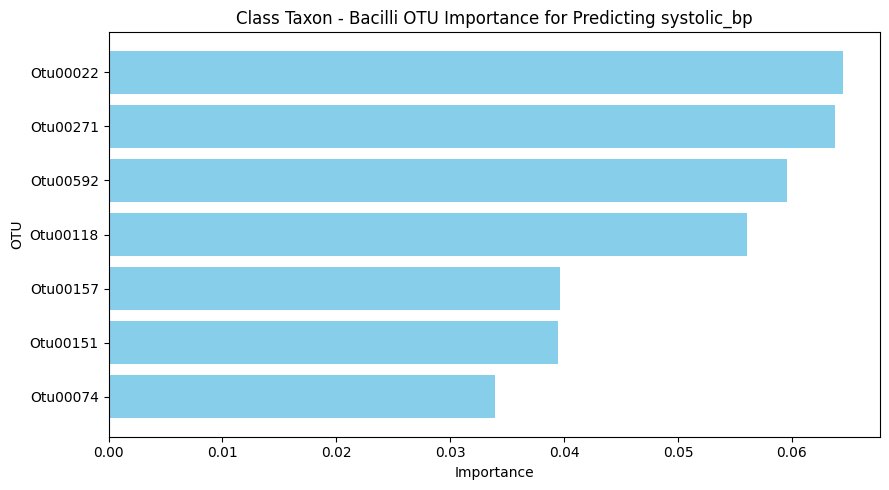

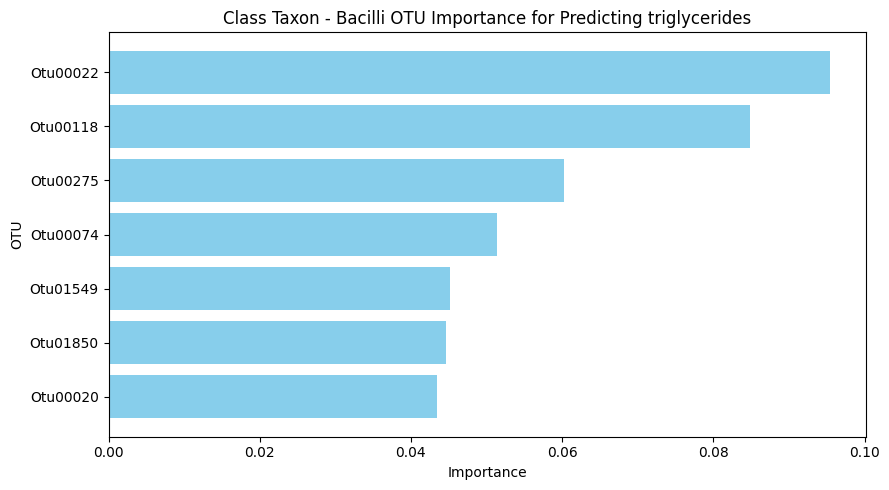

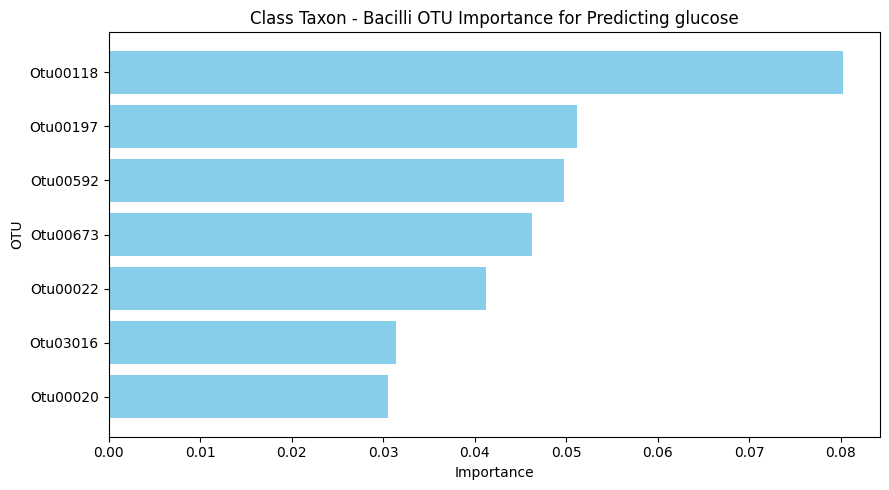

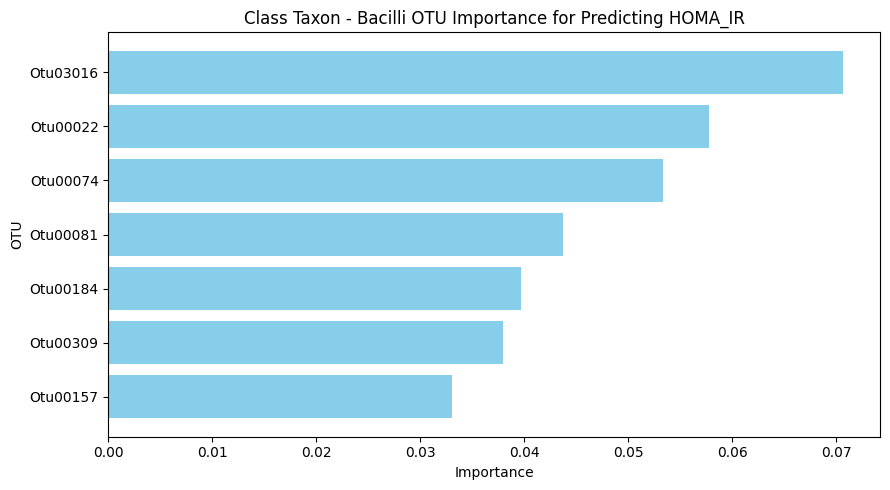

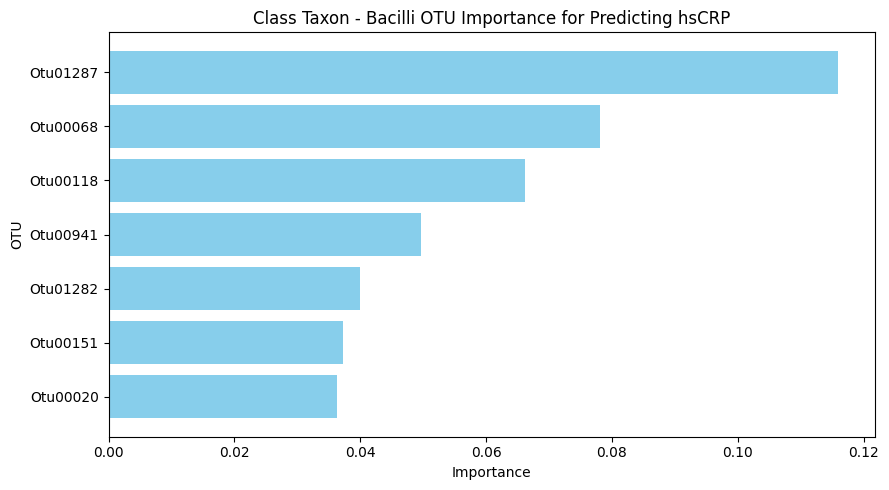

In [32]:
for variable in variables_chs:
    modelo_act = ab.single_specific_level_factors(otus = otu_filtered, 
                                               otu_taxonomy = taxo_df, 
                                               Y = antro_filtered[variable],
                                               Y_name = variable,
                                               level = 'Class', 
                                               specific = 'Bacilli',
                                               classification = False, 
                                               includes_ids = True, 
                                               max_rows = 7, 
                                               relative = True, 
                                               save_file = True,
                                               file_name = f"{variable}vsBacilli")